In [62]:
"""
Multi-armed bandit:
- A coin machine has N levers (arms) each with different expected wins
- The average wins are chosen based on gaussian (mean 0, variance 1)
- The rewards are then a gaussian centered on the average win and variance 1
"""

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [78]:
import abc
import numpy as np
from typing import *


"""
Definition of the environment: the problem
"""


Reward = float


class Distribution(abc.ABC):
    @abc.abstractmethod
    def __call__(self) -> Reward:
        pass

    
class MultiArmedBanditEnv:
    def __init__(self, arms_distributions: List[Distribution]):
        self.arms_distributions = arms_distributions
        self.actions = np.array(range(len(self.arms_distributions)))
    
    def get_state(self):
        return 0
    
    def get_actions(self):
        return self.actions
    
    def step(self, action) -> Reward:
        return self.arms_distributions[action]()
    

"""
Different approach to solve the problem
"""


def completely_random(environment: MultiArmedBanditEnv, epoch_count: int) -> List[Reward]:
    rewards = []
    actions = environment.get_actions()
    for action in np.random.choice(actions, size=epoch_count):
        rewards.append(environment.step(action))
    return rewards

    
def select_best_value(action_values):
    # TODO - check this is a valid kind of reservoir sampling
    highest_action = None
    highest_value = float('-inf')
    equal_actions_nb = 1
    for i, value in enumerate(action_values):
        if value > highest_value:
            highest_value = value
            highest_action = i
            equal_actions_nb = 1
        elif value == highest_value:
            equal_actions_nb += 1
            if np.random.randint(low=0, high=equal_actions_nb) == 0:
                highest_action = i
    return highest_action

    
def epsilon_greedy_action_value(environment: MultiArmedBanditEnv, epoch_count: int, epsilon: float) -> List[Reward]:
    rewards = []
    actions = environment.get_actions()
    action_values = np.zeros(len(actions))
    action_counts = np.ones(len(actions))
    
    for epoch in range(epoch_count):
        if np.random.uniform(low=0., high=1.) < epsilon:
            action_index = np.random.randint(low=0, high=len(actions))
        else:
            action_index = select_best_value(action_values)
        reward = environment.step(actions[action_index])
        action_values[action_index] += (1 / action_counts[action_index]) * (reward - action_values[action_index])
        action_counts[action_index] += 1
        rewards.append(reward)
    
    return np.array(rewards)


def greedy_action_value(environment: MultiArmedBanditEnv, epoch_count: int) -> List[Reward]:
    return epsilon_greedy_action_value(environment, epoch_count, epsilon=-1.)

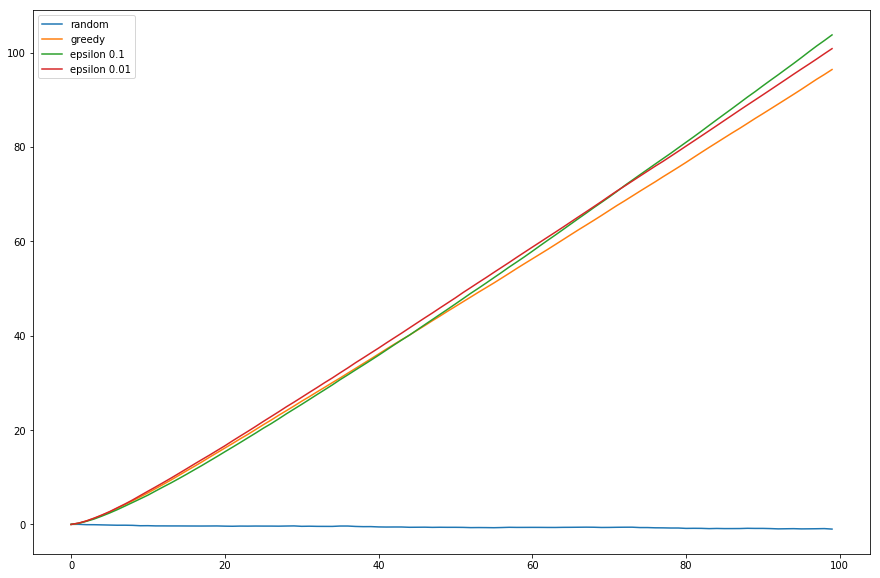

In [81]:
class GaussianDistribution(Distribution):
    def __init__(self, mean: float):
        self.mean = mean
        
    def __call__(self) -> Reward:
        return np.random.normal(loc=self.mean, scale=1)

    
def competition(round_count: int, epoch_by_round: int, arm_count: int):
    rewards_random = np.zeros(epoch_by_round)
    rewards_greedy = np.zeros(epoch_by_round)
    rewards_e01 = np.zeros(epoch_by_round)
    rewards_e001 = np.zeros(epoch_by_round)
    
    for i in range(round_count):
        means = np.random.normal(loc=0., scale=1., size=arm_count)    
        env = MultiArmedBanditEnv(arms_distributions=[GaussianDistribution(mean) for mean in means])
        rewards_random += 1 / (i+1) * (completely_random(env, epoch_by_round) - rewards_random)
        rewards_greedy += 1 / (i+1) * (greedy_action_value(env, epoch_by_round) - rewards_greedy)
        rewards_e01 += 1 / (i+1) * (epsilon_greedy_action_value(env, epoch_by_round, epsilon=0.1) - rewards_e01)
        rewards_e001 += 1 / (i+1) * (epsilon_greedy_action_value(env, epoch_by_round, epsilon=0.01) - rewards_e001)
        
    fig, ax = plt.subplots(figsize=(15, 10))
    time_steps = np.array(range(epoch_by_round))
    ax.plot(time_steps, rewards_random, label='random')
    ax.plot(time_steps, rewards_greedy, label='greedy')
    ax.plot(time_steps, np.cumsum(rewards_e01, label='epsilon 0.1')
    ax.plot(time_steps, np.cumsum(rewards_e001), label='epsilon 0.01')
    ax.legend()
    plt.show()

competition(round_count=2000, epoch_by_round=100, arm_count=10)